## Example 1

This example uses the supreme court corpus to compute some simple information:
- Which justices coordinate the most to others?
- Which justices are coordinated to the most?

In [1]:
import convokit

# set up corpus
corpus = convokit.Corpus(filename=convokit.download("supreme-corpus"))

In [2]:
# compute coordination scores on this corpus
coord = convokit.Coordination()
coord.fit(corpus)

# get coordination scores
coord.transform(corpus)

# get set of all justices
justices = list(corpus.iter_users(lambda user: user.meta["is-justice"]))
# get set of all users
everyone = list(corpus.iter_users())

# compute coordination from each justice to everyone
print("Justices, ranked by how much they coordinate to others:")
justices_to_everyone = coord.score(corpus, justices, everyone)
for justice, score in sorted(justices_to_everyone.averages_by_user().items(),
    key=lambda x: x[1], reverse=True):
    print(justice.name, round(score, 5))
print()

# compute coordination from everyone to each justice
print("Justices, ranked by how much others coordinate to them:")
everyone_to_justices = coord.score(corpus, everyone, justices, focus="targets")
for justice, score in sorted(everyone_to_justices.averages_by_user().items(), 
    key=lambda x: x[1], reverse=True):
    print(justice.name, round(score, 5))
print()

Justices, ranked by how much they coordinate to others:
justice thomas 0.12485
justice breyer 0.04606
justice o'connor 0.04432
justice souter 0.04118
justice scalia 0.03885
justice kennedy 0.03414
justice stevens 0.03193
justice ginsburg 0.02437
chief justice rehnquist 0.01977
chief justice roberts 0.01922
justice alito 0.01045

Justices, ranked by how much others coordinate to them:
chief justice rehnquist 0.08959
chief justice roberts 0.0664
justice ginsburg 0.05971
justice o'connor 0.056
justice stevens 0.04988
justice alito 0.0446
justice kennedy 0.04276
justice souter 0.04045
justice scalia 0.03438
justice thomas 0.03393
justice breyer 0.02758



## Example 2

This example uses the supreme court corpus to reproduce figures 4 and 5 from
  the echoes of power paper (https://www.cs.cornell.edu/~cristian/Echoes_of_power.html).

The plots answer these questions:
- Do lawyers coordinate more to justices than the other way around?
- Do lawyers coordinate more to unfavorable or favorable justices?
- Do unfavorable justices coordinate to lawyers more than favorable justices,
    or vice versa?

In [3]:
from convokit import Utterance, Corpus, Coordination, download

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [4]:
corpus = Corpus(filename=download("supreme-corpus"))

In [5]:
# helper function to plot two coordination scores against each other as a chart,
#   on aggregate and by coordination marker
# a is a tuple (speakers, targets)
# b is a tuple (speakers, targets)
def make_chart(a_scores, b_scores, a_description, b_description, a_color="b", b_color="g"):
    # get scores by marker and on aggregate
    _, a_score_by_marker, a_agg1, a_agg2, a_agg3 = coord.score_report(corpus, a_scores)
    _, b_score_by_marker, b_agg1, b_agg2, b_agg3 = coord.score_report(corpus, b_scores)

    # the rest plots this data as a double bar graph
    a_data_points = sorted(a_score_by_marker.items())
    b_data_points = sorted(b_score_by_marker.items())
    a_data_points, b_data_points = zip(*sorted(zip(a_data_points, b_data_points),
        key=lambda x: x[0][1], reverse=True))
    labels, a_data_points = zip(*a_data_points)
    _, b_data_points = zip(*b_data_points)

    labels = ["aggregate 1", "aggregate 2", "aggregate 3"] + list(labels)
    a_data_points = [a_agg1, a_agg2, a_agg3] + list(a_data_points)
    b_data_points = [b_agg1, b_agg2, b_agg3] + list(b_data_points)

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(a_data_points)) + 0.35)
    ax.set_xticklabels(labels, rotation="vertical")

    ax.bar(np.arange(len(a_data_points)), a_data_points, 0.35, color=a_color)
    ax.bar(np.arange(len(b_data_points)) + 0.35, b_data_points, 0.35, color=b_color)

    a_scores_a1 = [s for s in a_scores if len(a_scores[s]) == 8]
    b_scores_a1 = [s for s in b_scores
            if len(b_scores[s]) == 8]
    b_patch = mpatches.Patch(color="b",
                             label=a_description + " (total: " +
                             str(len(a_scores_a1)) + ", " +
                             str(len(a_scores)) + ")")
    g_patch = mpatches.Patch(color="g",
                             label=b_description + " (total: "  +
                             str(len(b_scores_a1)) + ", " +
                             str(len(b_scores)) + ")")
    plt.legend(handles=[b_patch, g_patch])

    filename = str(a_description) + " vs " + str(b_description) + ".png"
    plt.savefig(filename, bbox_inches="tight")
    print('Created chart "' + filename + '"')

Created chart "Target-unfavorable justice vs Target-favorable justice.png"
Created chart "Speaker-unfavorable justice vs Speaker-favorable justice.png"


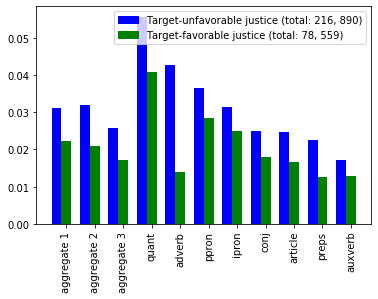

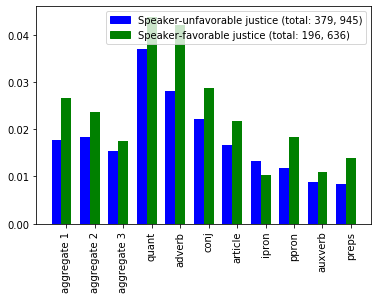

In [6]:
# split users by case id and split the justices by whether they are favorable to the current presenting side
# this treats the same person across two different cases as two different users
split = ["case", "justice-is-favorable"]

# create coordination object
coord = Coordination()
coord.fit(corpus)



# get all groups of users that we want to compare
everyone = list(corpus.iter_users())
justices = list(corpus.iter_users(lambda user: user.meta["is-justice"]))
lawyers = list(corpus.iter_users(lambda user: not user.meta["is-justice"]))

# do lawyers coordinate more to unfavorable or favorable justices?
make_chart(
    coord.score(corpus, lawyers, justices, focus="targets", target_thresh=6,
        speaker_thresh=6, split_by_attribs=split,
        target_attribs={"justice-is-favorable": False}),
    coord.score(corpus, lawyers, justices, focus="targets", target_thresh=6,
        speaker_thresh=6, split_by_attribs=split,
        target_attribs={"justice-is-favorable": True}),
    "Target-unfavorable justice", "Target-favorable justice"
)
# do unfavorable justices coordinate to lawyers more than favorable justices, or
#   vice versa?
make_chart(
    coord.score(corpus, justices, lawyers, target_thresh=6,
        split_by_attribs=split,
        speaker_attribs={"justice-is-favorable": False}),
    coord.score(corpus, justices, lawyers, target_thresh=6,
        split_by_attribs=split,
        speaker_attribs={"justice-is-favorable": True}),
    "Speaker-unfavorable justice", "Speaker-favorable justice"
)

## Example 3

This example uses the wikipedia conversations corpus to reproduce figure 1
  from the echoes of power paper (https://www.cs.cornell.edu/~cristian/Echoes_of_power.html).

The plots answer these questions: 
- Do users on the whole coordinate more to admins or nonadmins?
- Do admins coordinate to other people more than nonadmins do?

In [7]:
from convokit import Utterance, Corpus, Coordination, download

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [8]:
# load corpus; split users by whether they are an admin
# this means that if a user has spoken in the corpus as both an admin and
#   a non-admin, then we will split this user into two users, one for each of
#   these roles
corpus = Corpus(filename=download("wiki-corpus"))
split = ["is_admin"]

Dataset already exists at /Users/calebchiam/.convokit/downloads/wiki-corpus


In [9]:
# helper function to plot two coordination scores against each other as a chart,
#   on aggregate and by coordination marker
# a is a tuple (speakers, targets)
# b is a tuple (speakers, targets)
def make_chart(a_scores, b_scores, a_description, b_description, a_color="b", b_color="g"):
    # get scores by marker and on aggregate
    _, a_score_by_marker, a_agg1, a_agg2, a_agg3 = coord.score_report(corpus, a_scores)
    _, b_score_by_marker, b_agg1, b_agg2, b_agg3 = coord.score_report(corpus, b_scores)

    # the rest plots this data as a double bar graph
    a_data_points = sorted(a_score_by_marker.items())
    b_data_points = sorted(b_score_by_marker.items())
    a_data_points, b_data_points = zip(*sorted(zip(a_data_points, b_data_points),
        key=lambda x: x[0][1], reverse=True))
    labels, a_data_points = zip(*a_data_points)
    _, b_data_points = zip(*b_data_points)

    labels = ["aggregate 1", "aggregate 2", "aggregate 3"] + list(labels)
    a_data_points = [a_agg1, a_agg2, a_agg3] + list(a_data_points)
    b_data_points = [b_agg1, b_agg2, b_agg3] + list(b_data_points)

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(a_data_points)) + 0.35)
    ax.set_xticklabels(labels, rotation="vertical")

    ax.bar(np.arange(len(a_data_points)), a_data_points, 0.35, color=a_color)
    ax.bar(np.arange(len(b_data_points)) + 0.35, b_data_points, 0.35, color=b_color)

    a_scores_a1 = [s for s in a_scores if len(a_scores[s]) == 8]
    b_scores_a1 = [s for s in b_scores
            if len(b_scores[s]) == 8]
    b_patch = mpatches.Patch(color="b",
                             label=a_description + " (total: " +
                             str(len(a_scores_a1)) + ", " +
                             str(len(a_scores)) + ")")
    g_patch = mpatches.Patch(color="g",
                             label=b_description + " (total: "  +
                             str(len(b_scores_a1)) + ", " +
                             str(len(b_scores)) + ")")
    plt.legend(handles=[b_patch, g_patch])

    filename = str(a_description) + " vs " + str(b_description) + ".png"
    plt.savefig(filename, bbox_inches="tight")
    print('Created chart "' + filename + '"')

Created chart "Target-admins vs Target-nonadmins.png"
Created chart "Speaker-admins vs Speaker-nonadmins.png"


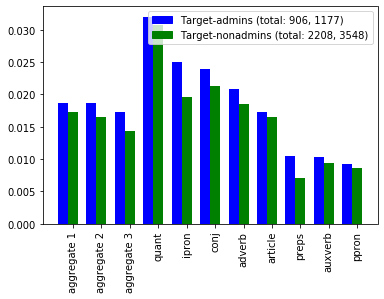

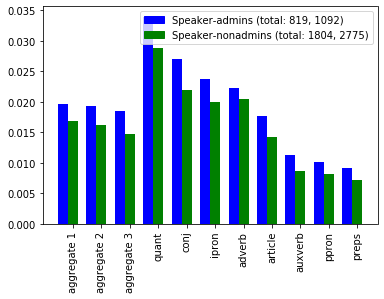

In [10]:
# create coordination object
coord = Coordination()
coord.fit(corpus)

# get all groups of users that we want to compare
everyone = set(corpus.iter_users())
admins = set(corpus.iter_users(lambda user: user.meta["is-admin"]))
nonadmins = everyone - admins

# do users on the whole coordinate more to admins or nonadmins?
make_chart(
    coord.score(corpus, everyone, admins, focus="targets", target_thresh=7,
        split_by_attribs=split),
    coord.score(corpus, everyone, nonadmins, focus="targets", target_thresh=7,
        split_by_attribs=split),
    "Target-admins", "Target-nonadmins"
)
# do admins coordinate to other people more than nonadmins do?
make_chart(
    coord.score(corpus, admins, everyone, speaker_thresh=7, target_thresh=7,
        split_by_attribs=split),
    coord.score(corpus, nonadmins, everyone, speaker_thresh=7, target_thresh=7,
        split_by_attribs=split),
    "Speaker-admins", "Speaker-nonadmins"
)